# Memory Management

In [14]:
import numpy as np
import cupy  as cp
from numba import vectorize, cuda

## Managing GPU Memory

Idea: allocate things to GPU memory, apply ufuncs, and get the results back from GPU memory

In [3]:
@vectorize(["float32(float32, float32)"], target='cuda')
def add_ufunc(x, y):
    return x + y

In [4]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [5]:
%timeit add_ufunc(x, y) # Baseline performance with host arrays

1.57 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are two ways that we can create GPU arrays to pass to Numba to avoid copy overhead
- Numba (not as fully features as CuPy, but may be useful if you don't need the rest of CuPy for your application)
- CuPy

In [8]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


In [9]:
%timeit add_ufunc(x_device, y_device)

608 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Further improvement: create the output buffer with teh numba.cuda.device_array() function
- avoid copy things back from GPU to CPU

In [10]:
out_device = cuda.device_array(shape=(n,), dtype = np.float32)

In [12]:
%timeit add_ufunc(x_device, y_device, out=out_device)

519 µs ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


when you want to get things back from GPU

In [13]:
out_host = out_device.copy_to_host()
print(out_host[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


## CuPy interoperability

Recent versions of CuPy(>=4.5) support Numba's generic CUDA array interace

We can see this on a CuPy array, by looking for the `__cuda_array_interface__` attributes

In [18]:
x_cp = cp.asarray(x)
y_cp = cp.asarray(y)
out_cp = cp.empty_like(y_cp)

x_cp.__cuda_array_interface__

{'shape': (100000,),
 'typestr': '<f4',
 'descr': [('', '<f4')],
 'data': (140345635904512, False),
 'version': 0}

This describes the CuPy array in a portable way so that other package, like Numba, can use it:

In [19]:
add_ufunc(x_cp, y_cp, out=out_cp)
print(out_cp[:10])

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


And it runs the same speed as using the Numba device allocation

In [20]:
%timeit add_ufunc(x_cp, y_cp, out=out_cp)

519 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Exercise

Given these ufuncs:

In [26]:
import numpy as np
import cupy  as cp
import math

from numba import vectorize, cuda
from matplotlib import pyplot as plt

In [23]:
@vectorize(['float32(float32, float32, float32)'], target="cuda")
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

In [24]:
n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

convert this code to use device allocations so that there are only host<-> device copies at the beginning and end and benchmark mperformance change. Use either CuPy arrays or Numba device allocations

In [25]:
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

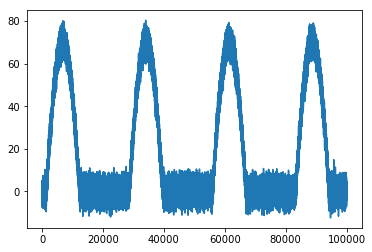

In [27]:
plt.plot(waveform)

My Answer:

In [29]:
t_cp     = cp.asarray(t)
noise_cp = cp.asarray(noise)
out_cp   = cp.empty_like(t)

In [35]:
pulses_cp = make_pulses(t_cp, period, 100.0)
add_ufunc(pulses_cp, noise_cp, out=out_cp)
out_return = cp.asnumpy(out_cp)

np.testing.assert_allclose(waveform, out_return)

In [36]:
%%timeit
pulses = make_pulses(t, period, 100.0)
waveform = add_ufunc(pulses, noise)

3.04 ms ± 5.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%timeit
pulses_cp = make_pulses(t_cp, period, 100.0)
add_ufunc(pulses_cp, noise_cp, out=out_cp)

1.76 ms ± 9.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
